In [ ]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D
from dataclasses import dataclass

In [ ]:
@dataclass
class LogisticRegression:

    datapath: str
    learning_rate: float
    max_iterations: int
    epsilon: float = 0.0005

    def __post_init__(self):
      self.X_train, self.X_test, self.y_train, self.y_test = self.read_data()


    def read_data(self):
      train_df = pd.read_excel(self.datapath, sheet_name = '2004--2005 Data')
      test_df = pd.read_excel(self.datapath, sheet_name = '2004--2007 Data')

      train_df = np.array(train_df, dtype=np.float64)
      test_df = np.array(test_df, dtype=np.float64)

      X_train, y_train = train_df[:, 1:], train_df[:, 0]
      X_test, y_test = test_df[:, 1], test_df[:, 0]

      return X_train, X_test, y_train, y_test

    def remove_index(self, X_train, y_train):
      # A function that deletes user-selected indexes
      input_indexes = input('Enter the indexes you want to remove (separated by space): ')
      indexes_to_remove = list(map(int, input_indexes.split()))
      print('Entered indexes:', indexes_to_remove)

      X_train = np.delete(X_train, indexes_to_remove, axis=0)
      y_train = np.delete(y_train, indexes_to_remove, axis=0)

      return X_train, y_train

    def addX0(self, X):
      return np.column_stack([np.ones([X.shape[0],1]), X])

    def normalize_train(self, X):
      mean = np.mean(X,0)
      std = np.std(X,0)
      X_norm = (X - mean) / std
      X_norm = self.add_x0(X_norm)
      return X_norm, mean, std

    def normalize_test(self, test_X, mean, std):
      X_norm = (test_X - mean) / std
      X_norm = self.add_x0(X_norm)
      return X_norm

    def sigmoid(self, z):
      sig = 1 / (1 + np.exp(-z))
      return sig

    def cost_function(self, X, y):
      sig = self.sigmoid(X.dot(self.w))
      pred_ = y * np.log(sig) + (1 - y) * np.log(1 - sig)
      cost = pred_.sum()
      return cost

    def cost_derivative(self, X, y):
      sig = self.sigmoid(X.dot(self.w))
      grad = (sig - y).dot(X)
      return grad

    def gradient_descent(self, X, y):
      errors=[]
      prev_error = float('inf')
      for i in tqdm(range(self.max_iterations),
                    colour = 'red'):
        self.w -= self.learning_rate * self.cost_derivative(X,y)
        error = self.cost_function(X,y)
        errors.append(error)
        if abs(prev_error - error) < self.epsilon:
          print('Model Stopped Learning')
          break
        prev_error = error

      self.plot_cost(errors)

    def predict(self, X):
      sig = self.sigmoid(X.dot(self.w))
      return np.around(sig)

    def evaluate(self, y, y_hat):
      y = (y==1)
      y_hat = (y_hat==1)

      accuracy = (y==y_hat).sum() / y.size
      precision = (y & y_hat).sum() / y_hat.sum()
      recall = (y & y_hat).sum() / y.sum()
      f_score = 2*(precision * recall) / (precision+recall)

      return accuracy, precision, recall, f_score

    def fit(self):
      # function for running the model
      self.X_train, self.X_test, self.y_train, self.y_test = self.read_data()
      print(self.X_train.shape)

      self.w = np.ones(self.X_train.shape[1], dtype=np.float64) * 0
      self.gradient_descent(self.X_train, self.y_train)
      print(self.w)

      y_hat_train = self.predict(self.X_train)
      accuracy, recall, precision, f_score = self.evaluate(self.y_train, y_hat_train)

      print('Training Accuracy: ', accuracy)
      print('Training Recall: ', recall)
      print('Training precision: ', precision)
      print('Training f_score: ', f_score)
      print('--------------------------------')
      print('Results without outliers', '\n'*5)

      self.X_train, self.y_train = self.remove_index(self.X_train, self.y_train)
      print(self.X_train.shape, self.y_train.shape)

      self.w = np.ones(self.X_train.shape[1], dtype=np.float64) * 0
      self.gradient_descent(self.X_train, self.y_train)
      print(self.w)

      y_hat_train = self.predict(self.X_train)
      accuracy, recall, precision, f_score = self.evaluate(self.y_train, y_hat_train)

      print('Training Accuracy: ', accuracy)
      print('Training Recall: ', recall)
      print('Training precision: ', precision)
      print('Training f_score: ', f_score)

      self.scatterPlt()
      self.plot()
      self.plot3D()



    def plot_cost(self,cost_sequence):

        s = np.array(cost_sequence)
        t = np.arange(s.size)

        fig, ax = plt.subplots()
        ax.plot(t,s)

        ax.set(xlabel = 'iterations', ylabel = 'cost' , title = 'cost trend')
        ax.grid()
        plt.legend(bbox_to_anchor=(1.05,1), loc=2,shadow=True)
        plt.show()



    def plot(self):
        plt.figure(figsize=(12,8))
        ax = plt.axes(projection='3d')

        # Data for three-dimensional scattered points
        ax.scatter3D(self.X_train[:, 0], self.X_train[:, 1],
                     self.sigmoid(self.X_train.dot(self.w)),
                     c = self.y_train[:], cmap='viridis', s=100);

        ax.set_xlim3d(55, 80)
        ax.set_ylim3d(80, 240)
        plt.xlabel('$x_1$ feature', fontsize=15)
        plt.ylabel('$x_2$ feature', fontsize=15, )
        ax.set_zlabel('$P(Y = 1|x_1, x_2)$', fontsize=15, rotation = 0)



    def scatterPlt(self):
        # evenly sampled points
        x_min, x_max = 55, 80
        y_min, y_max = 80, 240

        xx, yy = np.meshgrid(np.linspace(x_min, x_max, 250),
                             np.linspace(y_min, y_max, 250))
        grid = np.c_[xx.ravel(), yy.ravel()]
        probs = grid.dot(self.w).reshape(xx.shape)

        f, ax = plt.subplots(figsize=(14,12))


        ax.contour(xx, yy, probs, levels=[0.5], cmap="Greys", vmin=0, vmax=.6)


        ax.scatter(self.X_train[:, 0], self.X_train[:, 1],
                   c=self.y_train[:], s=50,
                   cmap="RdBu", vmin=-.2, vmax=1.2,
                   edgecolor="white", linewidth=1)

        plt.xlabel('x1 feature')
        plt.ylabel('x2 feature')


    def plot3D(self):
        # evenly sampled points
        x_min, x_max = 55, 80
        y_min, y_max = 80, 240

        xx, yy = np.meshgrid(np.linspace(x_min, x_max, 250),
                             np.linspace(y_min, y_max, 250))

        grid = np.c_[xx.ravel(), yy.ravel()]
        probs = grid.dot(self.w).reshape(xx.shape)
        fig = plt.figure(figsize=(14,12))
        ax = plt.axes(projection='3d')
        ax.contour3D(xx, yy, probs, 50, cmap='binary')

        ax.scatter3D(self.X_train[:, 0], self.X_train[:, 1],
                   c=self.y_train[:], s=50,
                   cmap="RdBu", vmin=-.2, vmax=1.2,
                   edgecolor="white", linewidth=1)

        ax.set_xlabel('x1')
        ax.set_ylabel('x2')
        ax.set_zlabel('probs')
        ax.set_title('3D contour')
        plt.show()



(46, 2)


100%|██████████| 100000/100000 [00:03<00:00, 31669.85it/s]


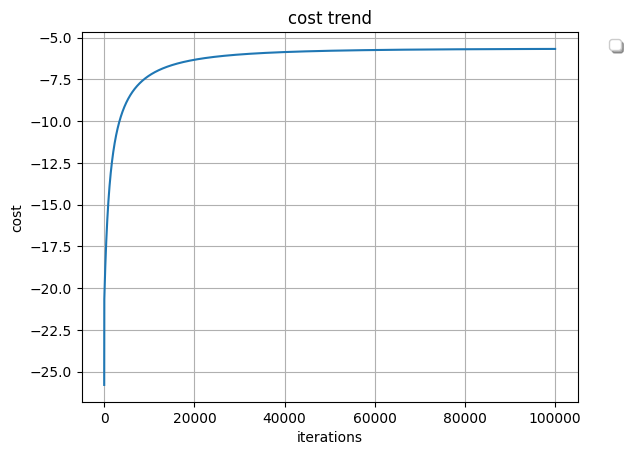

[-0.53977559  0.26130952]
Training Accuracy:  0.9565217391304348
Training Recall:  0.9722222222222222
Training precision:  0.9722222222222222
Training f_score:  0.9722222222222222
--------------------------------
Results without outliers 





Enter the indexes you want to remove (separated by space): 1 39
Entered indexes: [1, 39]
(44, 2) (44,)


100%|██████████| 100000/100000 [00:04<00:00, 23247.38it/s]


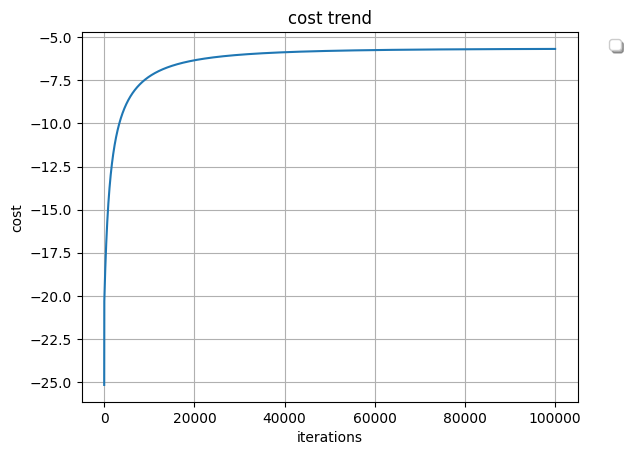

[-0.53806973  0.26047868]
Training Accuracy:  0.9545454545454546
Training Recall:  0.9705882352941176
Training precision:  0.9705882352941176
Training f_score:  0.9705882352941176


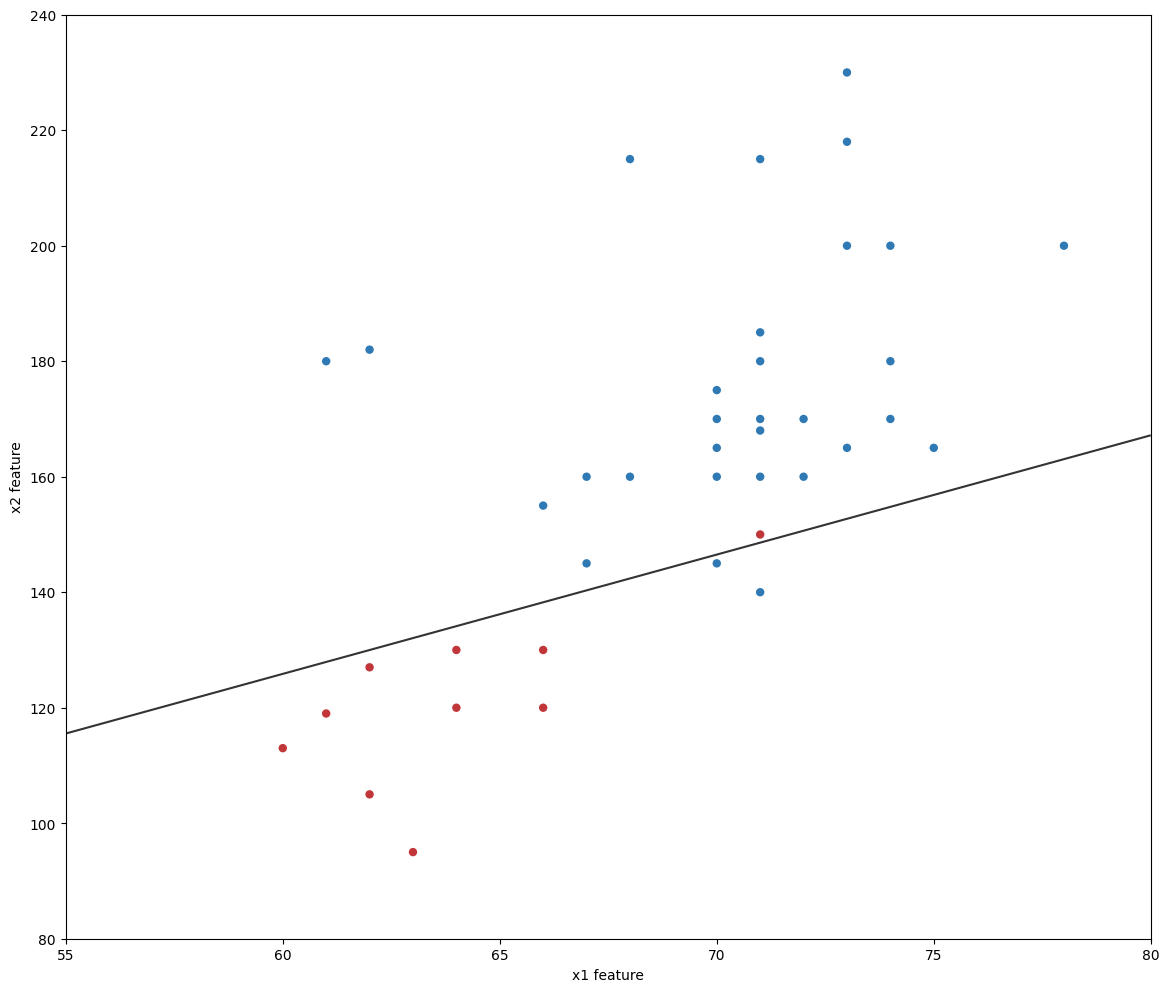

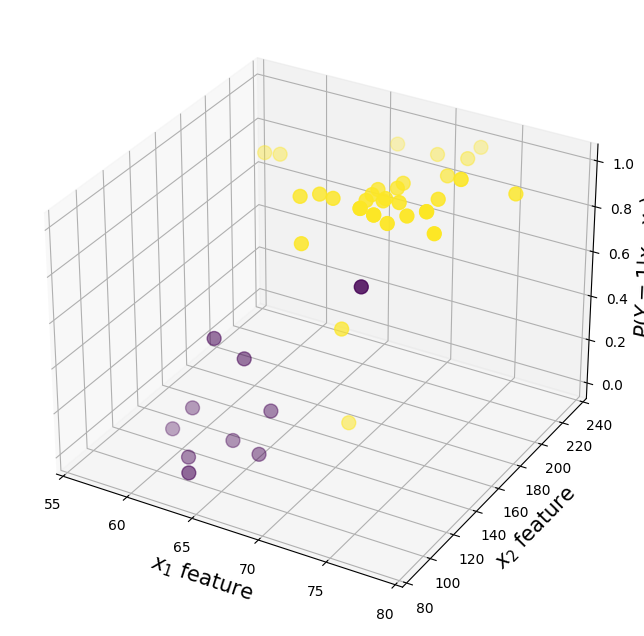

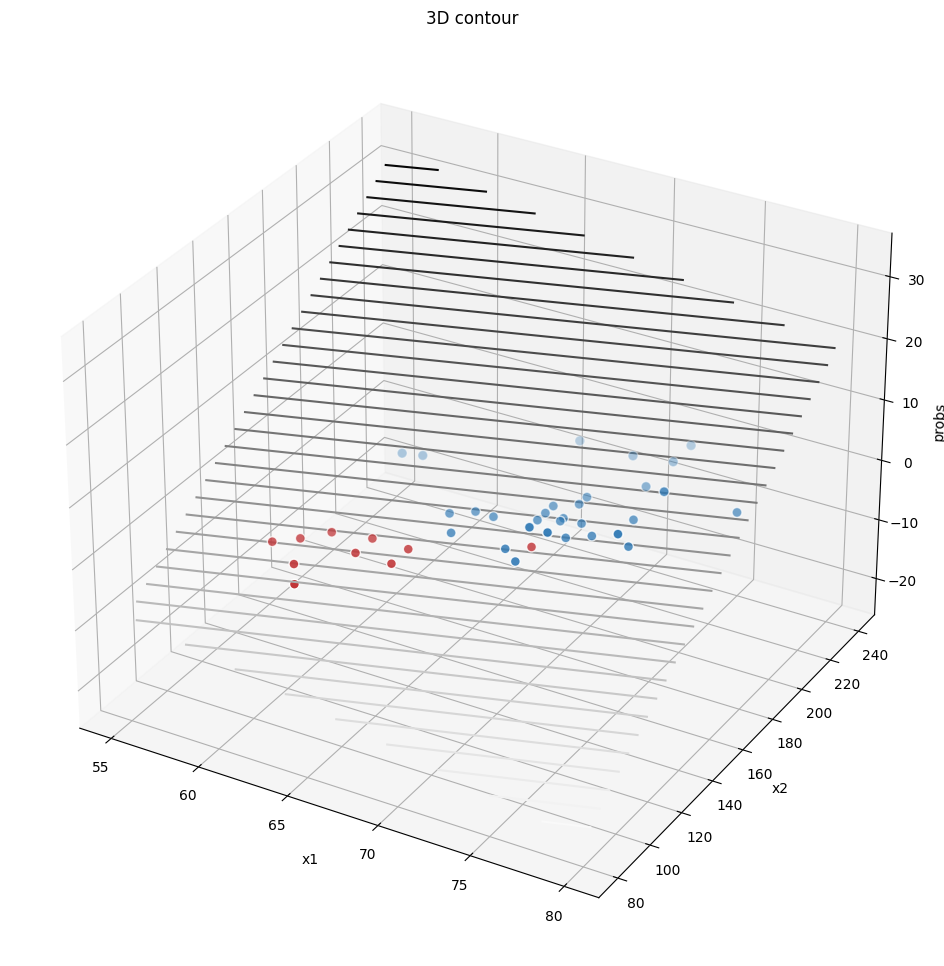

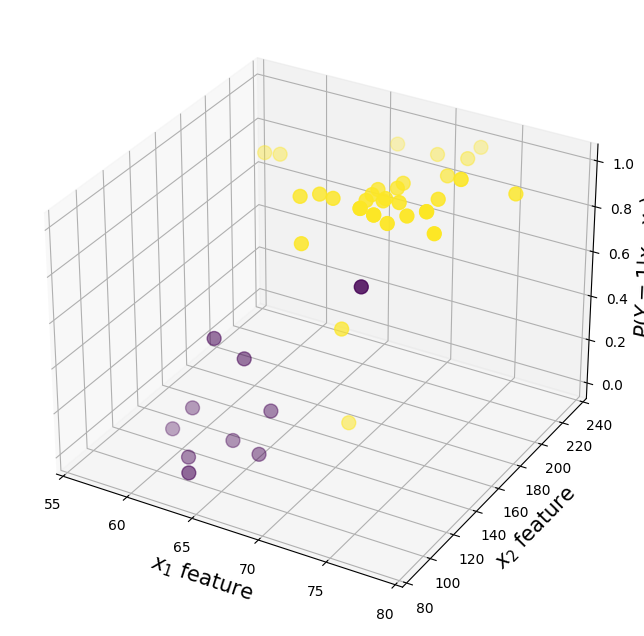

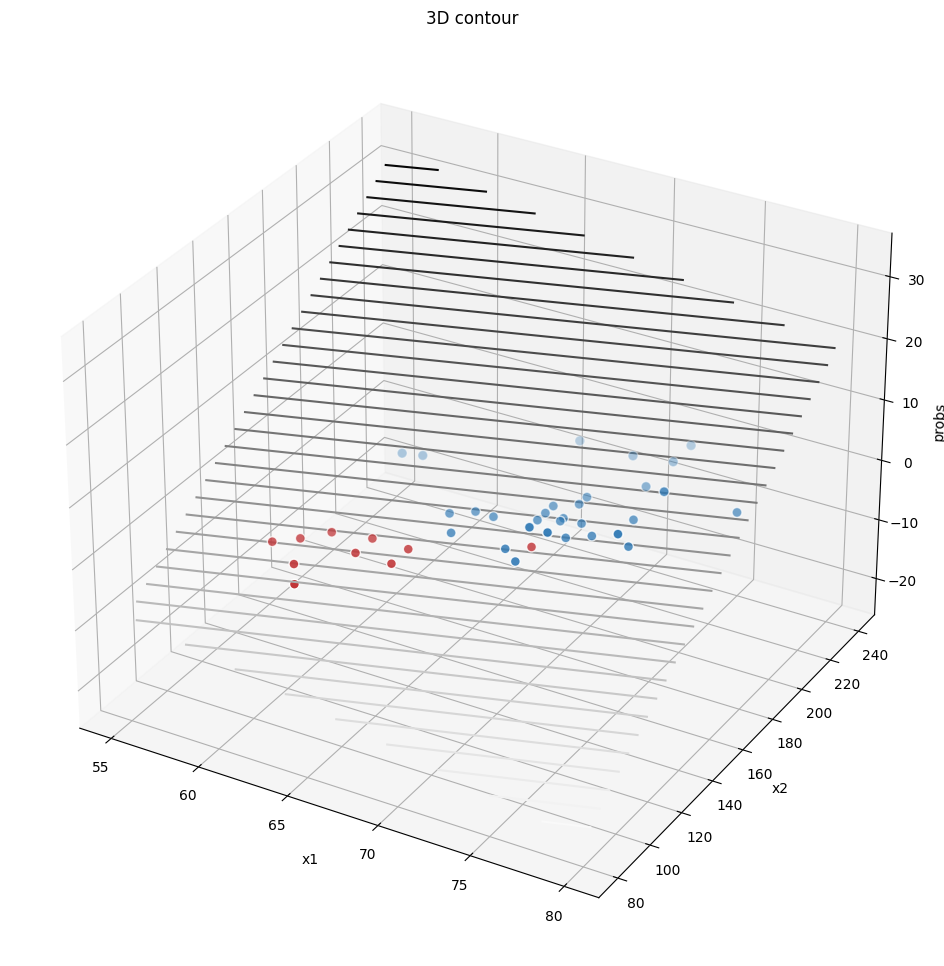

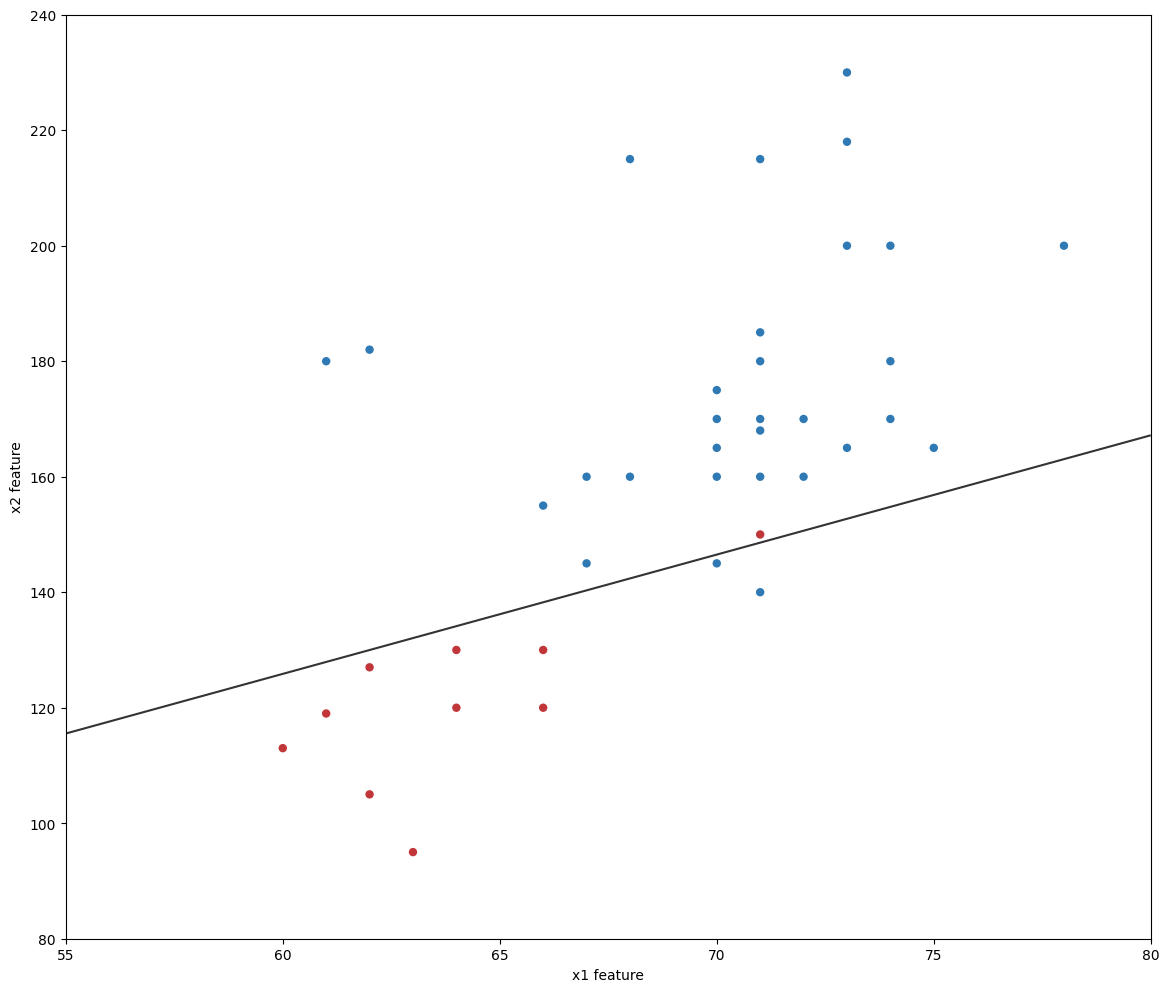

In [ ]:
lr = LogisticRegression(datapath = '/content/Lab3_data.xls', epsilon =0.0, learning_rate=0.1e-5, max_iterations=100000)
lr.fit()
lr.plot()
lr.plot3D()
lr.scatterPlt()